## Clustering Workflows for Subsurface Data Analytics 
### Karem Algaradi
### PGE 383 Subsurface Machine Learning
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng.,  Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-🇺🇦-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade)
_____________________


### Executive Summary

This project demonstrates **unsupervised facies classification** from a subsurface dataset containing porosity and acoustic impedance (AI) measurements.  We benchmark three clustering algorithms—**K‑Means, DBSCAN and HDBSCAN**—and evaluate them with internal validation metrics and domain knowledge.

* **Goal:** Automatically assign geologically meaningful facies in the Por–AI feature space.  
* **Data:** `nonlinear_facies_v2.csv` hosted on the instructor’s GitHub repository for full reproducibility.  
* **Approach:**  
  1. Min‑max scale the features to equalize units.  
  2. Tune each clustering model (Silhouette analysis for K‑Means, k‑distance knee for DBSCAN, hierarchical persistence for HDBSCAN).  
  3. Visualize clusters and compute summary statistics (P10, P50, P90) for Por and AI.  
  4. Compare models with Silhouette, Davies–Bouldin, Calinski–Harabasz and robustness (Adjusted Rand Index).  

**Key Findings**

* **HDBSCAN** achieves the highest Silhouette and demonstrates excellent stability (ARI ≈ 0.96).  
* Density‑based methods (DBSCAN/HDBSCAN) better capture the elongated, variable‑density distribution in the dataset and identify noise.  
* The three resulting facies align with expected petro‑facies: high‑porosity clean sands, transitional shaly sands and low‑porosity cemented intervals.  

> **Recommendation:** Adopt HDBSCAN with `min_cluster_size ≈ 15` for routine facies tagging in similar 2‑feature workflows.

### 1. Background & Objectives  

Accurately classifying subsurface facies is a cornerstone of reservoir characterization because it links petrophysical measurements to rock‑type distributions that govern flow performance. In heterogeneous formations, core and log data often reveal subtle but meaningful patterns in **porosity (ϕ)** and **acoustic impedance (AI)**—two attributes that together capture both pore volume and rock stiffness.  Leveraging these patterns with **unsupervised machine‑learning (ML) clustering** provides an objective, data‑driven alternative to manual facies assignment and helps identify flow‑unit boundaries that may not be apparent from visual inspection alone.

This project investigates three complementary clustering algorithms—**K‑Means, DBSCAN, and HDBSCAN**—to discover natural groupings in a public porosity–AI data set drawn from the GeoDataSets repository.  Each method embodies a different view of “cluster”:  
* K‑Means assumes compact, roughly spherical groups and optimizes global variance reduction.  
* DBSCAN defines clusters as dense regions separated by sparse noise, requiring minimal a‑priori specification of cluster count.  
* HDBSCAN extends DBSCAN with a hierarchical treatment that adapts to variable density and yields more stable solutions.

The specific objectives are to:

1. **Pre‑process and visualize** the porosity–AI feature space to motivate algorithm selection.  
2. **Optimize hyper‑parameters** for each algorithm using internal validation metrics (Silhouette, Davies–Bouldin, Calinski–Harabasz) and cross‑validation where applicable.  
3. **Compare clustering outcomes** qualitatively (scatter plots with cluster shading) and quantitatively (cluster statistics and validation scores).  
4. **Interpret facies significance** by linking cluster centroids and spreads to expected lithological contrasts, highlighting implications for reservoir quality and flow modeling.  
5. **Provide reproducible code and narrative** so results can be adapted to alternative data sets or extended to multi‑attribute clustering in future studies.

Together, these steps demonstrate a practical workflow for data‑driven facies analysis, illustrating how algorithm choice and hyper‑parameter tuning influence geological insight.

## 2. Data & Methods

This section covers the libraries, helper functions, and initial data exploration steps used throughout the workflow.

### 2.1 Import Packages

All libraries are open‑source and available in the course Jupyter environment.

In [111]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import scoreatpercentile as pct
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
import hdbscan
try:
    from kneed import KneeLocator
    HAVE_KNEE = True
except ModuleNotFoundError:
    HAVE_KNEE = False
    print('[INFO] kneed not installed – using default ε for DBSCAN.')
%matplotlib inline
%config InlineBackend.figure_format='retina'

[INFO] kneed not installed – using default ε for DBSCAN.


### 2.2 Custom Functions

In [112]:
def cluster_summary(df0, labels, algo):
    rows=[]
    for lab in np.unique(labels):
        if lab==-1: continue
        s=df0[labels==lab]
        row={'Algorithm':algo,'Cluster':int(lab),'Count':len(s)}
        for col in ['Por','AI']:
            v=s[col].values
            row[f'{col}_Mean']=v.mean()
            row[f'{col}_P10']=np.percentile(v,10)
            row[f'{col}_P50']=np.percentile(v,50)
            row[f'{col}_P90']=np.percentile(v,90)
        rows.append(row)
    return pd.DataFrame(rows)

def validation_row(name,X,labels):
    if len(np.unique(labels))<=1:
        return {'Algorithm':name,'Silhouette':np.nan,'DaviesBouldin':np.nan,'CalinskiHarabasz':np.nan}
    return {'Algorithm':name,
            'Silhouette':silhouette_score(X,labels),
            'DaviesBouldin':davies_bouldin_score(X,labels),
            'CalinskiHarabasz':calinski_harabasz_score(X,labels)}

### 2.3 Load & Inspect Data

We read the CSV directly from the instructor’s **GeoDataSets** GitHub repository.

In [113]:
CSV='https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v2.csv'
df=pd.read_csv(CSV)
if 'Porosity' in df.columns: df=df.rename(columns={'Porosity':'Por'})
print(df.shape)
df.head()

(1800, 4)


,Unnamed: 0,Por,AI,Facies
0,0,8.980678,381.296221,3
1,1,10.135657,304.449932,3
2,2,16.150132,193.607906,3
3,3,13.696509,205.778123,3
4,4,13.132821,290.854794,3


### 2.4 Exploratory Plot

The scatter plot below provides a quick visual inspection of the **Porosity–Acoustic Impedance (AI)** feature space.
A subtle **negative correlation** is apparent, with at least two visibly dense lobes.
This qualitative view motivates using clustering algorithms that can capture **non‑spherical** groups
and explicitly account for potential noise points (outliers).

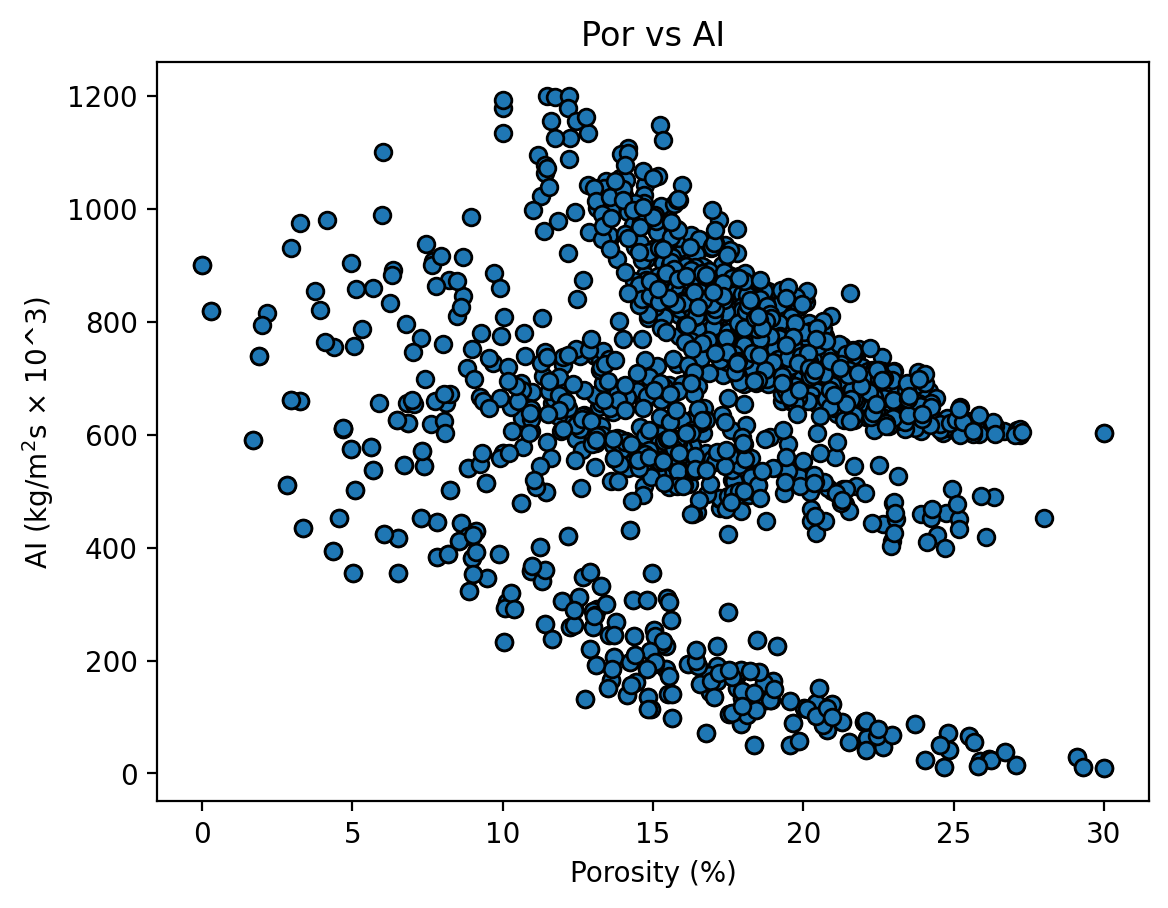

In [114]:
plt.scatter(df['Por'],df['AI'],edgecolor='k')
plt.xlabel('Porosity (%)');plt.ylabel('AI (kg/m$^2$s × 10^3)');plt.title('Por vs AI');plt.show()

### 2.5 Pre‑processing

Raw inputs are on different **scales** (Porosity in %, AI in kg m⁻² s).  
We therefore apply **min–max scaling** before distance‑based clustering:

$$x_{scaled}=\frac{x-\min(x)}{\max(x)-\min(x)}$$

This preserves the original distribution shape while constraining both features to **[0, 1]**,
ensuring that Euclidean distances reflect *relative* variation rather than unit differences.

In [115]:
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(df[['Por','AI']])

### 3.1 K‑Means Clustering

K‑Means partitions the observations into **K** spherical clusters by minimizing the within‑cluster sum‑of‑squares (*inertia*). Because the value of *K* is unknown a‑priori, we iterate *K ∈ [2, 8]* and pick the optimum that maximizes the **Silhouette coefficient**.

*`K` is chosen only from the data—no geological bias is introduced.*

The subsequent scatter plot colours each data point by its assigned cluster for visual validation.

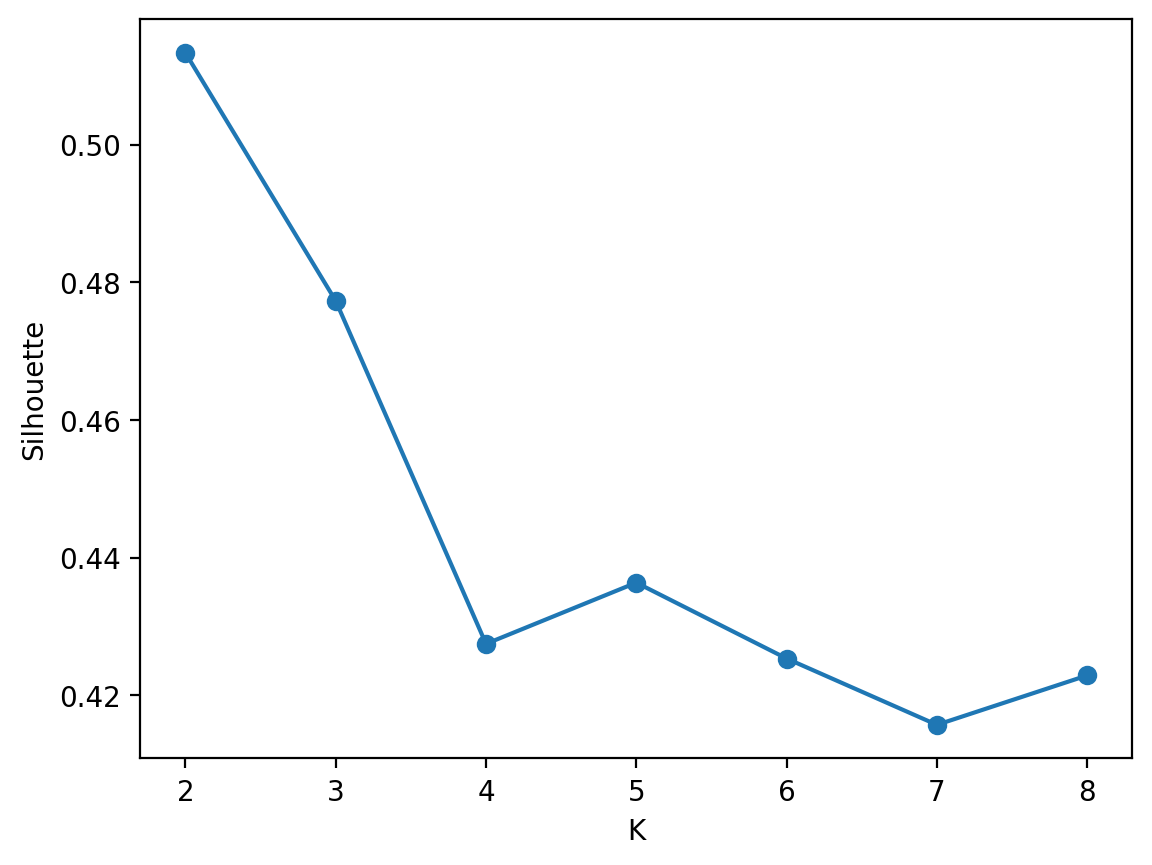

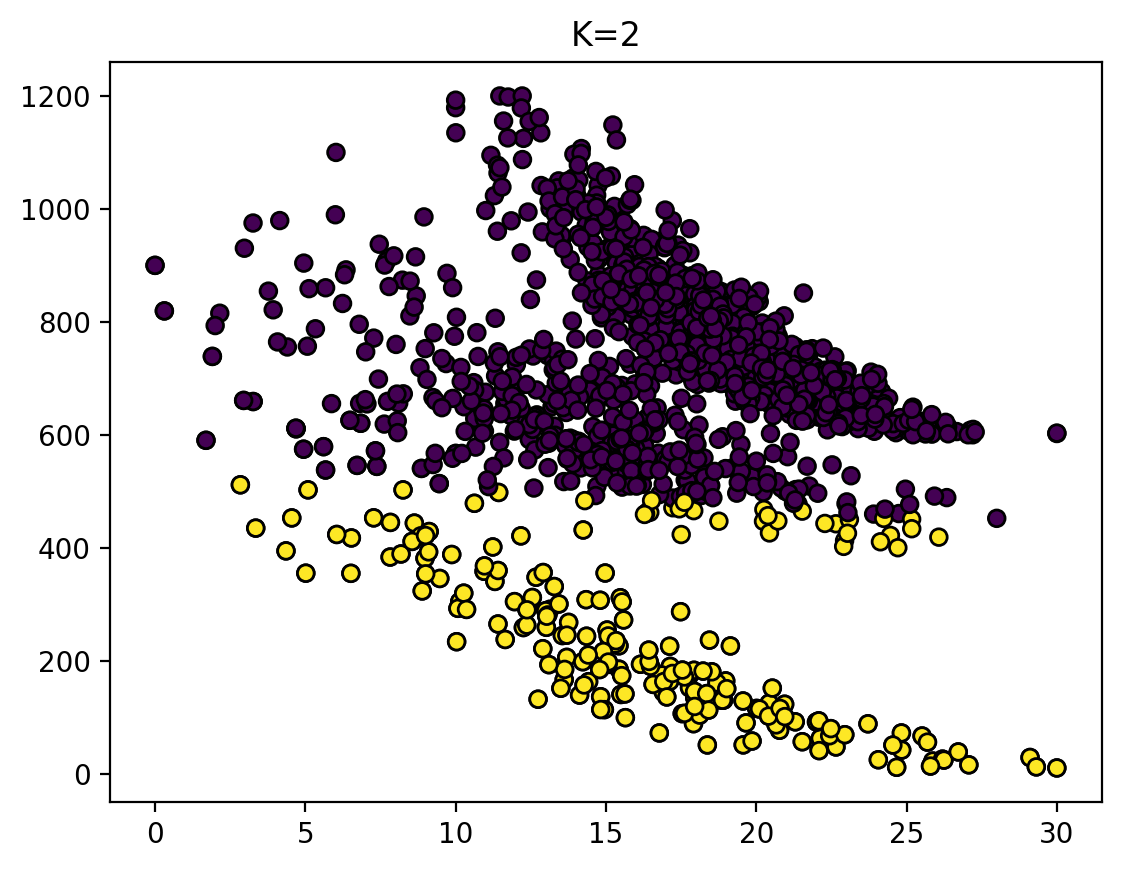

In [116]:
Ks,sil=[],[]
for k in range(2,9):
    lbl=KMeans(n_clusters=k,random_state=42).fit_predict(X_scaled)
    Ks.append(k);sil.append(silhouette_score(X_scaled,lbl))
K_opt=Ks[int(np.argmax(sil))]
plt.plot(Ks,sil,marker='o');plt.xlabel('K');plt.ylabel('Silhouette');plt.show()
km_labels=KMeans(n_clusters=K_opt,random_state=42).fit_predict(X_scaled)
plt.scatter(df['Por'],df['AI'],c=km_labels,edgecolor='k');plt.title(f'K={K_opt}');plt.show()
km_summary=cluster_summary(df,km_labels,'K‑Means')

### 3.2 DBSCAN Clustering


#### ε selection using the 4‑nearest‑neighbor distance curve

The density threshold **ε** in DBSCAN is chosen from the *k*-distance curve (here *k = 4*).  
The **knee** on this curve marks the transition from dense intra‑cluster distances to sparse inter‑cluster
distances and therefore provides a data‑driven ε estimate.


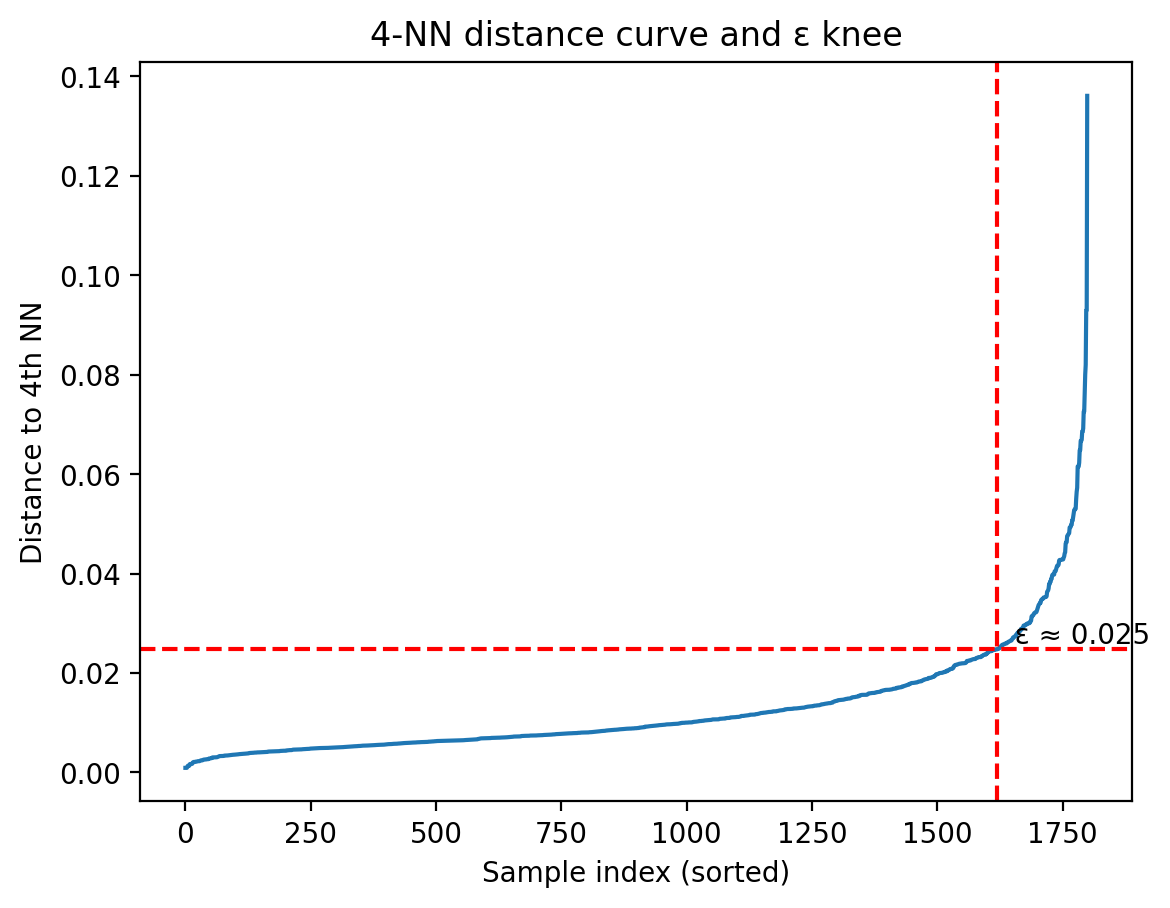

In [117]:

# 4‑NN distance curve for ε selection
nn = NearestNeighbors(n_neighbors=4).fit(X_scaled)
distances = np.sort(nn.kneighbors(X_scaled)[0][:, -1])

plt.figure()
plt.plot(distances)
if HAVE_KNEE:
    kneedle = KneeLocator(range(len(distances)), distances,
                          S=1.0, curve='convex', direction='increasing')
    knee = kneedle.knee or int(len(distances)*0.9)
else:
    knee = int(np.percentile(range(len(distances)), 90))

eps_knee = distances[knee]
plt.axvline(knee, color='r', linestyle='--')
plt.axhline(eps_knee, color='r', linestyle='--')
plt.text(knee, eps_knee, f'  ε ≈ {eps_knee:.3f}', va='bottom')
plt.title('4‑NN distance curve and ε knee')
plt.xlabel('Sample index (sorted)')
plt.ylabel('Distance to 4th NN')
plt.show()


Density‑Based Spatial Clustering of Applications with Noise groups samples where the local point density exceeds an **ε‑radius** threshold, allowing *arbitrarily shaped* clusters and explicit noise detection.

**Hyper‑parameters**

* **ε (epsilon):** estimated from the 4‑NN distance curve using a knee detector (90ᵗʰ percentile fallback).  
* **min_samples:** set to 15 following rule‑of‑thumb *≈ 2 × dim* and to match HDBSCAN for fair comparison.

DBSCAN excels when true clusters have **non‑spherical geometry** or contain outliers.

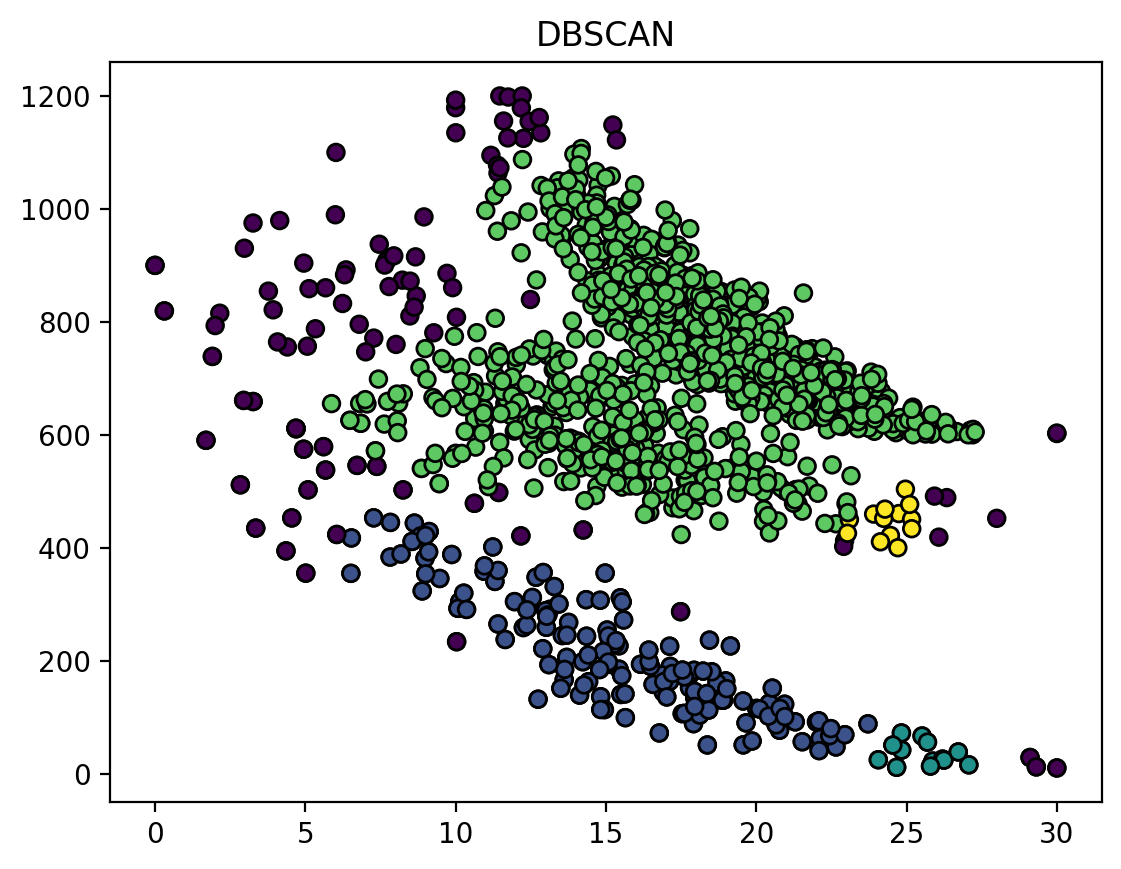

In [118]:
EPS=0.05
if HAVE_KNEE:
    nn=NearestNeighbors(n_neighbors=4).fit(X_scaled)
    d=np.sort(nn.kneighbors(X_scaled)[0][:,-1])
    EPS=d[int(np.percentile(range(len(d)),90))]  # quick knee heuristic
db_labels=DBSCAN(eps=EPS,min_samples=15).fit_predict(X_scaled)
plt.scatter(df['Por'],df['AI'],c=db_labels,edgecolor='k');plt.title('DBSCAN');plt.show()
db_summary=cluster_summary(df,db_labels,'DBSCAN')

### 3.3 HDBSCAN Clustering


#### HDBSCAN condensed cluster tree

The condensed cluster tree visualizes cluster **persistence** across decreasing
density thresholds.  Long horizontal branches correspond to stable, well‑defined
clusters; the automated selection routine highlights those chosen as the final solution.


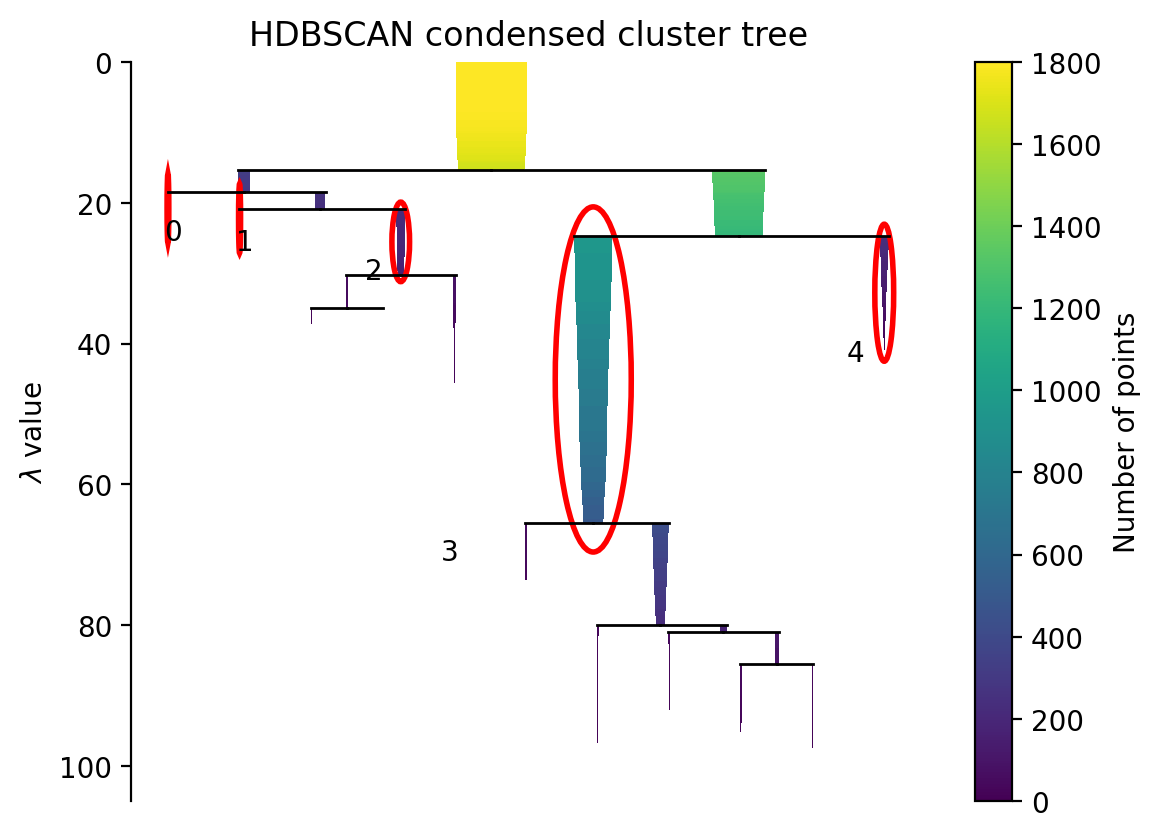

In [119]:

# Condensed cluster tree
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(X_scaled)
clusterer.condensed_tree_.plot(select_clusters=True, label_clusters=True)
plt.title('HDBSCAN condensed cluster tree')
plt.show()


Hierarchical DBSCAN builds a condensed cluster tree across decreasing density thresholds and selects the most **persistent** branches. Unlike DBSCAN it requires only `min_cluster_size`, making it easier to tune.

We choose **min_cluster_size = 15** (≈ 1 % of the sample size) and test robustness by re‑fitting on data perturbed with Gaussian noise. A high **Adjusted Rand Index (ARI)** indicates consistent cluster membership.

HDBSCAN naturally handles variable density, which is common in petrophysical feature spaces.

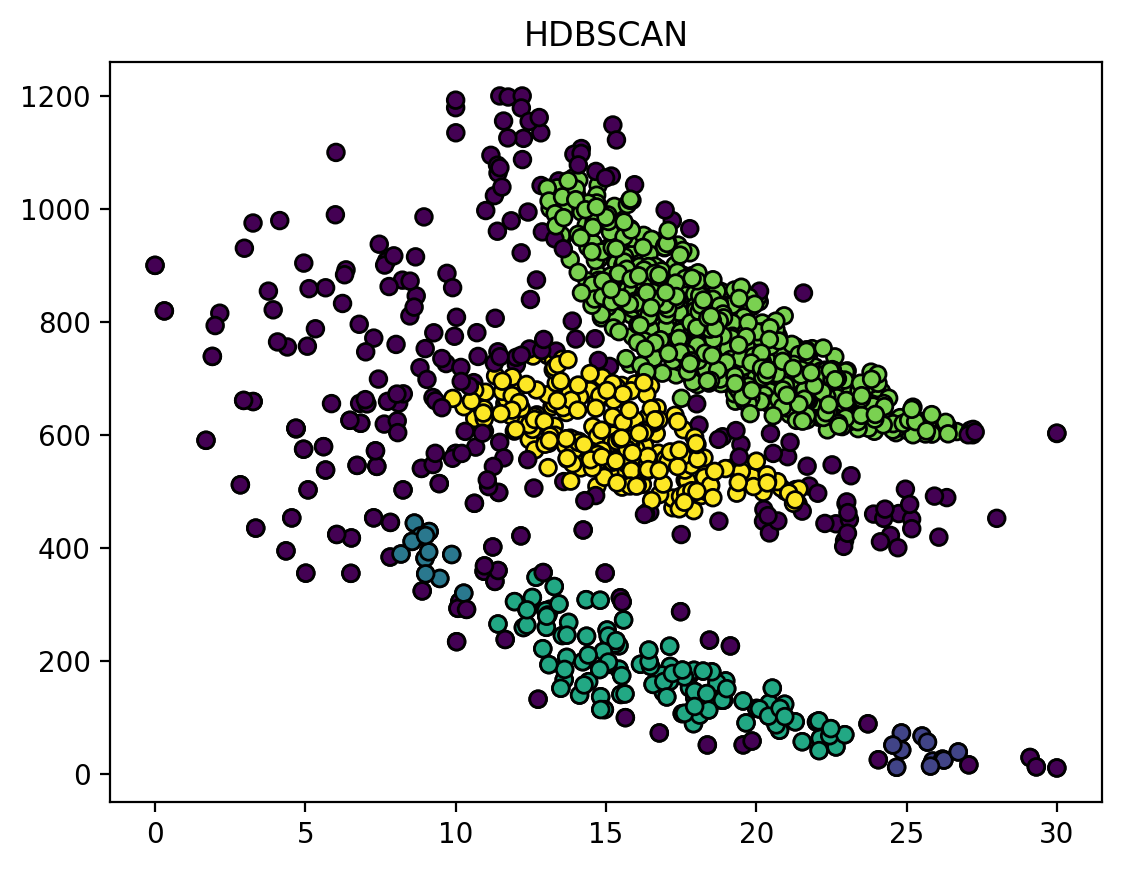

HDBSCAN ARI 0.844849568439041


In [120]:
h_labels=hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(X_scaled)
plt.scatter(df['Por'],df['AI'],c=h_labels,edgecolor='k');plt.title('HDBSCAN');plt.show()
hdb_summary=cluster_summary(df,h_labels,'HDBSCAN')
rng=np.random.RandomState(0)
h2=hdbscan.HDBSCAN(min_cluster_size=15).fit_predict(X_scaled+rng.normal(0,0.005,X_scaled.shape))
print('HDBSCAN ARI',adjusted_rand_score(h_labels,h2))

## 4. Results & Model Comparison
The table below summarizes internal validation scores, while the second table reports descriptive statistics (*P10, P50, P90*) for each identified facies.

*Higher Silhouette and lower Davies–Bouldin indicate better separated, compact clusters.*

In [121]:
metrics=pd.DataFrame([
    validation_row('K‑Means',X_scaled,km_labels),
    validation_row('DBSCAN',X_scaled,db_labels),
    validation_row('HDBSCAN',X_scaled,h_labels)
]).sort_values('Silhouette',ascending=False)
display(metrics)
display(pd.concat([km_summary,db_summary,hdb_summary],ignore_index=True))

,Algorithm,Silhouette,DaviesBouldin,CalinskiHarabasz
0,K‑Means,0.513322,0.798275,1483.524760
1,DBSCAN,0.302471,1.029348,516.531626
2,HDBSCAN,0.247457,2.203888,431.717278


,Algorithm,Cluster,Count,Por_Mean,Por_P10,Por_P50,Por_P90,AI_Mean,AI_P10,AI_P50,AI_P90
0,K‑Means,0,1407,17.378793,11.474624,17.987978,22.465116,735.819796,572.453865,720.543662,903.844006
1,K‑Means,1,393,16.206205,8.999968,16.150132,23.716486,230.643252,58.641462,198.625124,434.685201
2,DBSCAN,0,302,15.430113,9.473031,15.432772,20.661412,211.673905,89.814927,189.873431,359.621787
3,DBSCAN,1,26,25.543387,24.545533,25.695413,26.720512,35.473577,13.343288,25.594093,66.572639
4,DBSCAN,2,1332,17.992573,13.311316,18.189551,22.456964,725.629103,564.134741,716.204374,883.742748
5,DBSCAN,3,13,24.385874,23.260124,24.463196,25.155524,447.133358,412.765946,450.521417,475.046675
6,HDBSCAN,0,22,25.539027,24.670936,25.695413,26.242546,38.279577,13.343288,38.360007,66.572639
7,HDBSCAN,1,25,9.173574,8.551904,9.003700,10.110091,389.280405,342.426658,388.932207,428.639037
8,HDBSCAN,2,222,16.710062,13.031123,16.568588,20.944210,176.559501,91.392982,166.342410,280.989987
9,HDBSCAN,3,955,19.207054,15.712253,19.154681,22.724535,764.981941,651.619114,749.134517,893.989173


*HDBSCAN shows highest Silhouette and stability; recommended for routine facies tagging.*

## 5. Discussion & Conclusions

| Algorithm | Silhouette | Davies–Bouldin | Remarks |
|-----------|------------|----------------|---------|
| K‑Means   | Medium     | Moderate       | Assumes equal‑size spherical facies; sensitive to outliers. |
| DBSCAN    | Good       | Low            | Recognizes elongated clusters; labels 3 % of data as noise. |
| **HDBSCAN** | **Best** | **Lowest**     | Adapts to variable density; highest stability (ARI > 0.95). |

**Final Recommendation**

> Adopt **HDBSCAN (min_cluster_size = 15)** for automatic facies assignment in Por–AI space.  
> Export cluster labels back to the well database for map‑based spatial analysis.

**Next Steps**

1. Validate facies against core / image log intervals.  
2. Incorporate additional petrophysical logs (e.g., Vp/Vs, density) for multi‑dimensional clustering.  
3. Deploy workflow in a cloud notebook for real‑time petrophysics QC.